# SciDB and Machine Learning on Wearable Data

This work is motivated by the following publication out of the IHI 2012 - 2ND ACM SIGHIT International Health Informatics Symposium: https://dl.acm.org/citation.cfm?doid=2110363.2110375

The authors explored ways to detect sleep using a wrist-worn accelerometer and light sensor. In this Notebook, we explore their data loaded in SciDB via a few queries and analytics. We'll start off by running simple fetch and summary queries to familiarize ourselves with the data. Then we'll explore ways to use SciDB streaming to bring analytics _to_ the data and execute data-wide computations in the cluster. Finally, we'll build towards a machine learning algorithm that can detect sleep with some accuracy.

The objective of this work is not so much to train a good model, but to demonstrate the SciDB-powered workflow itself. The key take-away is that SciDB helps easily orchestrate parallelism for complex calculations that can be expressed in popular languages like R and Python. 

# 1. Connect and Explore

The Usual AMI password is 'Paradigm4' - enter it when prompted.

In [1]:
from scidbpy import connect
import getpass
import requests
import warnings
warnings.filterwarnings("ignore")
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
db = connect(scidb_url="https://localhost:8083", 
             scidb_auth=('root', getpass.getpass('Please enter your password: ')),
             verify=False)

Please enter your password: ········


We loaded all of the data from the paper into a single array, indexed by 
 * `subject`: a simple numeric identifier,
 * `day`: a simple counter starting at day 0 for each subject and 
 * `mil`: the number of milliseconds elapsed since start of day (0 to 86,400,000).
 
Each cell in the array has the following attributes:
 * `acc_x,y,z`: the 3D accelerometer readings
 * `light`: the light sensor output
 * `sleep`: the "ground truth" as to whether or not the subject is sleeping at that time (1 means awake, 2 means asleep)

Let's take a look at a few entries:

In [2]:
ihi_schema = db.show(db.arrays.IHI_DATA)[:]['schema'][0]
ihi_schema

u'IHI_DATA<acc_x:double,acc_y:double,acc_z:double,light:double,sleep:double> [subject=0:*:0:1; day=0:*:0:1; mil=0:86399999:0:3600000]'

In [3]:
db.summarize(db.arrays.IHI_DATA)[:]

,inst,attid,att,count,bytes,chunks,min_count,avg_count,max_count,min_bytes,avg_bytes,max_bytes
0,0,0,all,91469568.0,4.091912e+09,25596.0,135.0,21441.530239,190458.0,80.0,159865.298015,4571016.0


In [4]:
db.limit(db.arrays.IHI_DATA, 5)[:]

,subject,day,mil,acc_x,acc_y,acc_z,light,sleep
0,0,1,509,109.0,117.0,146.0,0.0,2.0
1,0,1,580,109.0,117.0,146.0,0.0,2.0
2,0,1,2454,109.0,117.0,146.0,0.0,2.0
3,0,1,2515,109.0,117.0,146.0,0.0,2.0
4,0,1,2821,109.0,117.0,146.0,0.0,2.0


## 1.1 Quick Fetch and Browse Routines

Because SciDB indexes and clusters data on dimensions, it is efficient to retrieve time slices. Below we'll define a function `get_series` that will let us quickly retrieve data for specific subject, day and time intervals:

In [5]:
#A helper time conversion routine
from datetime import time
def time_to_millis(t):
    return long(t.hour * 3600000 + t.minute * 60000 + t.second * 1000 + long(t.microsecond / 1000))

def get_series(subject, day, t_start, t_end):
    if type(t_start) is time:
        t_start = time_to_millis(t_start)
    if type(t_end) is time:
        t_end = time_to_millis(t_end)
    query = db.filter(db.arrays.IHI_DATA, "subject = {} and day = {} and mil>={} and mil <={}".format(
            subject, day, t_start, t_end))
    return query[:]

d = get_series(subject=0, day=1, t_start = time(8,30,0), t_end=time(9,30,0))
d.head()

,subject,day,mil,acc_x,acc_y,acc_z,light,sleep
0,0,1,32401301,127.0,112.0,151.0,0.0,2.0
1,0,1,32403894,127.0,112.0,151.0,0.0,2.0
2,0,1,32406487,127.0,112.0,151.0,0.0,2.0
3,0,1,32409080,127.0,112.0,151.0,0.0,2.0
4,0,1,32411672,127.0,112.0,151.0,0.0,2.0


The timeseries are downloaded as Pandas dataframes and we can easily visualize them. We'll create quick plotter function below and visualize subject 0, day 1, from 8:50 AM to 9:30 AM. Looks like our subject is waking up at right around that time:

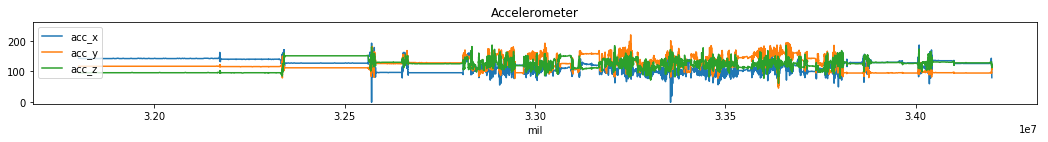

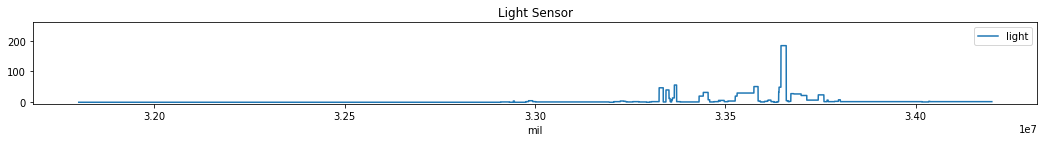

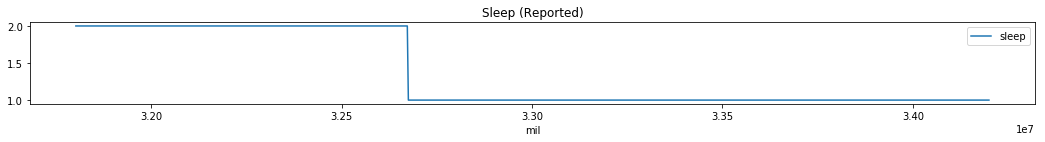

In [6]:
import matplotlib.pyplot as plt

def plot_series(d):
    d = d.sort_values(by='mil')
    plt.rcParams['figure.figsize'] = (18, 1.5)
    d1 =d[['mil','acc_x','acc_y','acc_z']]
    d1.plot(x='mil', ylim=(-5,260), title='Accelerometer')
    d2 =d[['mil','light']]
    d2.plot(x='mil', ylim=(-5,260), title = 'Light Sensor')
    d3 =d[['mil','sleep']]
    d3.plot(x='mil', ylim=(0.95,2.05), title = 'Sleep (Reported)')
    plt.show(block=True)

def get_and_plot(subject, day, t_start, t_end):
    d = get_series(subject = subject, day = day, t_start = t_start, t_end = t_end)
    plot_series(d)
    
get_and_plot(subject=0, day=1, t_start = time(8,50,0), t_end=time(9,30,0))

For another example - looks like Subject 3 stayed up late on the morning of Day 3. They go to sleep sometime between midnight and 1 AM:

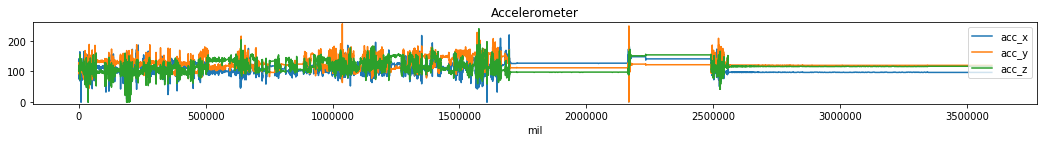

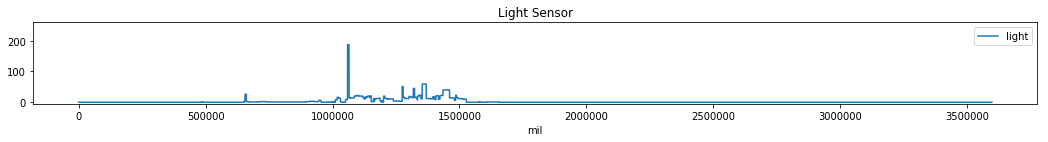

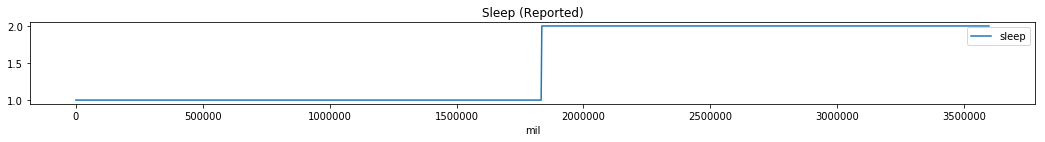

In [7]:
get_and_plot(subject=3, day=3, t_start = time(0,0,0), t_end=time(1,0,0))

We can also easily aggregate data into a daily summary. From this we can see most have good coverage but sometimes data is missing. Day 0 usually does not start at midnight. 

In [8]:
daily_summary = db.aggregate(
        db.apply(
            db.arrays.IHI_DATA, 
            "mil", "mil"
        ),
        "count(*) as num_samples", 
        "min(mil) as t_start", 
        "max(mil) as t_end",
        "subject", "day"
    )[:]
daily_summary.sort_values(by=['subject','day']).head()

,subject,day,num_samples,t_start,t_end
136,0,0,44427.0,76984000.0,86399979.0
102,0,1,407427.0,509.0,86399500.0
122,0,2,853878.0,2095.0,86398429.0
13,0,3,895450.0,1037.0,86398973.0
171,0,4,334253.0,1026.0,86398314.0


# 2. Analytics: Computing an Activity Score

Let's try to calculate the total "amount of movement" that the subject is performing. There are many different approaches in the literature: counting the number of times the accelerometer crosses a threshold (ZCM), proportional integration (PIM), time above threshold and so on. It is also recommended to pre-filter the signal to exlude vibrations that are not of human origin. In this particular case we don't have a lot of information about the device (a custom made prototype) nor even what units the acceleration is captured in. 

We'll create a simple example function that will add up Euclidean acceleromter distances from the current reading to the previous reading, over a fixed time window (15 minutes). Thus for each 15-minute window, the user gets an "activity" score sum. The score is 0 when the accelerometer series as flat. The more change there is, the higher the score.

Down the road, we'll show how to use streaming to execute the arbitrary supplied function on all data in parallel. We'll then leave the development of a more realistic function to the user:

In [9]:
def binned_activity(d):
    import pandas as pd
    bin_millis = 60000 * 15
    d1 = d[['mil', 'acc_x','acc_y','acc_z']]
    d2 = d1.shift(1)
    d2.columns = ['mil_0', 'acc_x_0', 'acc_y_0', 'acc_z_0']
    dm = pd.concat([d1,d2], axis=1)
    dm['activity'] = pow(pow(dm['acc_x'] - dm['acc_x_0'], 2) + 
                     pow(dm['acc_y'] - dm['acc_y_0'], 2) + 
                     pow(dm['acc_z'] - dm['acc_z_0'], 2), 0.5)
    dm['bin'] = (dm['mil'] / (bin_millis)).astype(long)
    dmm = dm.groupby(['bin'], as_index=False)[['activity']].sum()
    dmm['mil'] = dmm['bin'] * bin_millis + (bin_millis/2)
    dmm['subject'] = d['subject'][0]
    dmm['day'] = d['day'][0]
    dmm = dmm[['subject', 'day', 'mil', 'activity']]
    return(dmm)

We can now run our function on an example timeseries and plot it alongside. Our activity score increases as the subject wakes up:

   subject  day       mil      activity
0        0    1  31050000   2874.772235
1        0    1  31950000   1703.148437
2        0    1  32850000  47860.275432
3        0    1  33750000  64244.561334


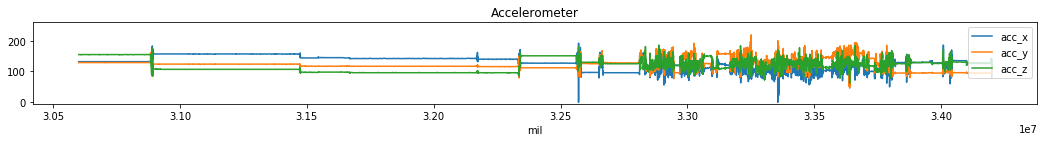

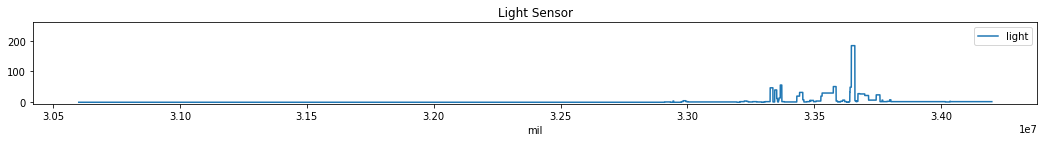

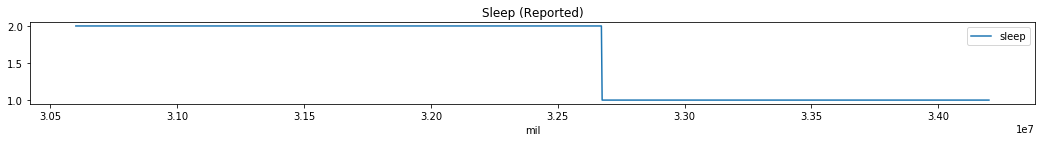

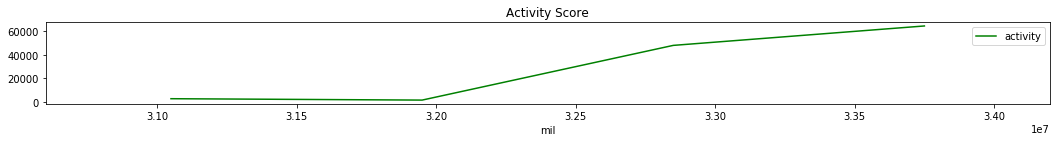

In [10]:
d = get_series(subject=0, day=1, t_start = time(8,30,0), t_end=time(9,30,0))
dm = binned_activity(d)
print(dm)
plot_series(d)
dm[['mil','activity']].plot(x='mil', color='green', title = "Activity Score", 
                           xlim=(min(d['mil']), max(d['mil'])  ))
plt.show(block=True)

## 2.1 Applying a Function through Streaming

Taking our `binned_activity` function from above we will now do the following in SciDB:
 1. Upload the code for `binned_activity` to the SicDB cluster
 2. In parallel, run `binned_activity` on every subject, ouputting the activity for every 15-minute period
 3. Gather and store results as a new array `IHI_BINNED_ACTIVITY`
 
SciDB makes this quite straightforward, modulo a few small aspects. SciDB streaming will execute the function on one chunk of data at a time, and the `IHI_DATA` array is chunked into 1-hour intervals. The 15 minute windows evenly divide the hour, thus we won't see any overlap issues. If the window were, say, 23 minutes, we would need to write some extra code to redimension the data prior to streaming.

Note also the `import pandas as pd` line is _inside_ the body of the function. This is not common but will do the right thing: Python is smart enough to import modules only once.

In [11]:
#Remove the array if exists
try:
    db.remove(db.arrays.IHI_BINNED_ACTIVITY)
except:
    print("Array not found")

### 2.1.1 Notes on Streaming and Python Environments

Very often foks use custom enviroments and additional package managers like Conda. If that's the case, keep in mind that the `python` process that is invoked by SciDB's `stream()` is the default Python process for the Linux user that's running the database. Note also that the `stream` process does not run in an interactive shell. So, typically, executing a `python` command inside `stream` will run `/usr/bin/python` even if Conda is configured otherwise for user `scidb`.

However, we can easily add some paths for a differnet environment. For example, the scidbstrm package comes with a nice `python_map` shorthand:

In [12]:
import scidbstrm
scidbstrm.python_map

'\'python -uc "import scidbstrm; scidbstrm.map(scidbstrm.read_func())"\''

To run from a different Python environment, all we need to do is prepend some environment exports:

In [13]:
snowflake_python_map='''\'
export VIRTUAL_ENV="/home/scidb/anaconda2/envs/snowflakes"
export PATH="$VIRTUAL_ENV/bin:$PATH"
python -uc "import scidbstrm; scidbstrm.map(scidbstrm.read_func())" \' '''

For more notes about Conda, environments and non-interactive shells, see a helpful post here: https://gist.github.com/datagrok/2199506

For more notes about Streaming and security, see 
https://github.com/paradigm4/stream#stability-and-security

We now use our script to run the `binned_activity` function on all data:

In [14]:
#ETA on this is about 1 minute
import scidbstrm
db_fun = db.input(upload_data=scidbstrm.pack_func(binned_activity)).store()
db.stream(
    db.apply(
        db.arrays.IHI_DATA, 
        "mil, mil", 
        "subject, subject", 
        "day, day"
    ),
    snowflake_python_map,
    "'format=feather'",
    "'types=int64,int64,int64,double'",
    "'names=subject,day,mil,activity'",
    '_sg({}, 0)'.format(db_fun.name)
).store(db.arrays.IHI_BINNED_ACTIVITY)

Array(DB('https://localhost:8083', ('root', PASSWORD_PROVIDED), None, None, False), 'IHI_BINNED_ACTIVITY')

Notice that after the streaming the array now has "placeholder" dimensions and we've converted our `subject` and `day` fields to attributes:

In [15]:
db.show(db.arrays.IHI_BINNED_ACTIVITY)[:]['schema'][0]

u'IHI_BINNED_ACTIVITY<subject:int64,day:int64,mil:int64,activity:double> [instance_id=0:15:0:1; chunk_no=0:*:0:1; value_no=0:*:0:1073741824]'

In [16]:
db.limit(db.arrays.IHI_BINNED_ACTIVITY, 5).fetch(atts_only=True).sort_values(by=['subject','day'])

,subject,day,mil,activity
0,0.0,1.0,22050000.0,7326.537944
1,0.0,1.0,22950000.0,1071.618620
2,0.0,1.0,23850000.0,838.910822
3,0.0,1.0,24750000.0,3992.496487
4,0.0,5.0,83250000.0,100668.998112


We can fetch a whole day's worth of activity for a particular subject. It's also interesting to look at inter-day and inter-subject comparisons of peak activity times:

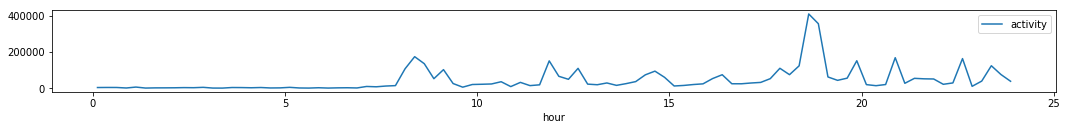

In [17]:
s2_day3_activity = db.filter(
                      db.arrays.IHI_BINNED_ACTIVITY,
                      "subject = 2 and day = 3"
                    )[:]
s2_day3_activity = s2_day3_activity.sort_values(by='mil')
s2_day3_activity['hour'] = s2_day3_activity['mil'] / 3600000
s2_day3_activity[['hour','activity']].plot(x='hour')
plt.show(block=True)

Finally, we can compare the average activity level across subjects. It's an interesting illustration, however one should keep in mind that it's vulnerable to device-to-device variation as well as missing data:

In [18]:
activity_stats = db.grouped_aggregate(
                         db.grouped_aggregate(
                            db.arrays.IHI_BINNED_ACTIVITY,
                            "sum(activity) as daily_activity", "subject, day"
                        ),
                        "avg(daily_activity) as avg_daily_activity", 
                        "stdev(daily_activity) as stdev_daily_activity",
                        "count(*) as num_days",
                        "subject"
                     ).fetch(atts_only=True)
activity_stats

,subject,avg_daily_activity,stdev_daily_activity,num_days
0,7,3.119218e+05,1.355315e+05,25.0
1,0,4.528213e+06,1.954187e+06,15.0
2,1,2.210951e+06,1.281339e+06,65.0
3,6,7.318961e+05,2.773511e+05,28.0
4,4,4.643156e+06,1.684177e+06,17.0
5,3,4.044635e+06,1.247038e+06,27.0
6,2,2.736731e+06,1.707209e+06,25.0
7,5,2.620769e+06,1.079851e+06,5.0


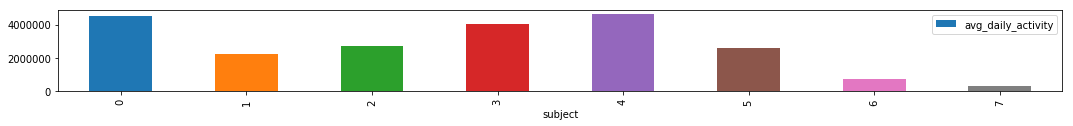

In [19]:
activity_stats.sort_values(by='subject').plot(y='avg_daily_activity', x='subject', kind ='bar')
plt.show()

Our `binned_activity` function is a very rough prototype but we'll draw attention to how easy it is to modify that function - adding a filter, interpolating, taking a more realistic integral - and re-run on all the data using SciDB.

# 3. In-Database Machine Learning

We'll build up on the streaming paradigm seen above to execute a machine learning exercise on the data. We'll perform the following:

 1. Compute several binned features on the data - binned variance for accelerometers and the total amount of light as measured by the light sensor
 2. Randomly split the binned features into "training" and "validation" sets
 3. Use the Stochastic Gradient Descent Classifier from scikit-learn to train several models on the training set inside SciDB in Parallel
 4. Combine the trained models into a single Voting Classifier prediction model, store that as an array in SciDB.
 5. Evaluate the model on the remaining "validation" set and compare it to ground truth.
 
Many of these steps are built on this blog post: http://rvernica.github.io/2017/10/streaming-machine-learning
In fact we use a very similar classifier. Consult that post for additional clarifications.

First, the binning can be done entirely using SciDB aggregation. The splitting into "training" and "validation" is achieved by `apply`-ing a value to each field that is either 0 or 1.

In [20]:
try:
    db.remove(db.arrays.IHI_BINNED_FEATURES)
except:
    print("Array not found")

In [21]:
feature_binning_period = 1 * 60 * 1000 #Break up the data into 1-minute bins
db.apply(
    db.grouped_aggregate(
        db.apply(
         db.arrays.IHI_DATA, 
         "bin_millis", "mil/({p}) * ({p}) + ({p})/2".format(p=feature_binning_period)
        ),
        "sum(light) as total_light", 
        "var(acc_x) as acc_x_var", 
        "var(acc_y) as acc_y_var", 
        "var(acc_z) as acc_z_var", 
        "max(sleep) as sleep",
        "subject, day, bin_millis"
    ),
    "training", "random()%2"
).store(db.arrays.IHI_BINNED_FEATURES)
db.op_count(db.arrays.IHI_BINNED_FEATURES)[:]

,i,count
0,0,253537.0


## 3.1 Training the Partial Models

Note the binned dataset is smaller than the original and it's surely possible to download it. Here we'll illustrate an in-DB parallel approach that will scale well for hundreds of such subjects. Note the use of filter with `training=1` which will use only the "training" half of the data.

We train the models in parallel:

In [22]:
import scidbstrm
class Train:
    model = None
    count = 0

    @staticmethod
    def map(df):
        dft = df[['acc_x_var','acc_y_var', 'acc_z_var', 'total_light']]
        Train.model.partial_fit(numpy.matrix(dft),
                                df['sleep'],
                                [1,2])
        Train.count += len(df)
        return None

    @staticmethod
    def finalize():
        if Train.count == 0:
            return None
        buf = io.BytesIO()
        sklearn.externals.joblib.dump(Train.model, buf)
        return pandas.DataFrame({
            'count': [Train.count],
            'model': [buf.getvalue()]})

ar_fun = db.input(upload_data=scidbstrm.pack_func(Train)).store()

#Once again, don't forget our environment variables:
python_run = """'
export VIRTUAL_ENV="/home/scidb/anaconda2/envs/snowflakes"
export PATH="$VIRTUAL_ENV/bin:$PATH"
python -uc "
import io
import numpy
import pandas
import scidbstrm
import sklearn.externals
import sklearn.linear_model

Train = scidbstrm.read_func()
Train.model = sklearn.linear_model.SGDClassifier()
scidbstrm.map(Train.map, Train.finalize)
"'"""

que = db.stream(
    db.filter(
        db.arrays.IHI_BINNED_FEATURES, 
        #Note: computed variance can be NULL if a bin input segment (1 minute) has only a single value in it
        "training=1 and acc_x_var is not null and acc_y_var is not null and acc_z_var is not null"
    ),
    python_run,
    "'format=feather'",
    "'types=int64,binary'",
    "'names=count,model'",
    '_sg({}, 0)'.format(ar_fun.name)
).store(
    db.arrays.IHI_PARTIAL_MODEL)

For each instance that had binned data there's now a model decorated with the number of rows that it was trained on:

In [23]:
db.scan(db.arrays.IHI_PARTIAL_MODEL)[:]

,instance_id,chunk_no,value_no,count,model
0,12,0,0,15827.0,�csklearn.linear_model.stochastic_gradient\nS...
1,0,0,0,8054.0,�csklearn.linear_model.stochastic_gradient\nS...
2,11,0,0,16010.0,�csklearn.linear_model.stochastic_gradient\nS...
3,1,0,0,16077.0,�csklearn.linear_model.stochastic_gradient\nS...
4,10,0,0,15816.0,�csklearn.linear_model.stochastic_gradient\nS...
5,2,0,0,7971.0,�csklearn.linear_model.stochastic_gradient\nS...
6,5,0,0,15513.0,�csklearn.linear_model.stochastic_gradient\nS...
7,15,0,0,15695.0,�csklearn.linear_model.stochastic_gradient\nS...
8,4,0,0,16000.0,�csklearn.linear_model.stochastic_gradient\nS...


## 3.2 Combining the Models

In a fashion very similar to Dr. Vernica's blog post, we combine all the partially-trained models:

In [24]:
def merge_models(df):
    import io
    import pandas
    import sklearn.ensemble
    import sklearn.externals
    estimators = [sklearn.externals.joblib.load(io.BytesIO(byt))
                  for byt in df['model']]
    if not estimators:
        return None
    labelencoder = sklearn.preprocessing.LabelEncoder()
    labelencoder.fit([0,1,2])
    model = sklearn.ensemble.VotingClassifier(())
    model.estimators_ = estimators
    model.le_ = labelencoder
    buf = io.BytesIO()
    sklearn.externals.joblib.dump(model, buf)
    return pandas.DataFrame({'count': df.sum()['count'],
                             'model': [buf.getvalue()]})

ar_fun = db.input(upload_data=scidbstrm.pack_func(merge_models)).store()

que = db.unpack(
    #The unpack puts all the models into a single chunk (assuming there aren't more than 1M instances)
    db.arrays.IHI_PARTIAL_MODEL,
    "i", 
    "10000000"
).stream(
    snowflake_python_map,
    "'format=feather'",
    "'types=int64,binary'",
    "'names=count,model'",
    '_sg({}, 0)'.format(ar_fun.name)
).store(
db.arrays.IHI_FINAL_MODEL)

In [25]:
db.scan(db.arrays.IHI_FINAL_MODEL)[:]

,instance_id,chunk_no,value_no,count,model
0,15,0,0,126963.0,�csklearn.ensemble.voting_classifier\nVotingC...


## 3.3 Making Predictions

Now that we have our model, we can use it to make predictions. Below we'll run it on the remainder of the data, filtering for `training = 0`. 

In [26]:
try:
    db.remove(db.arrays.IHI_PREDICTED_SLEEP)
except:
    print("Array not found")

In [27]:
class Predict:
    model = None
    @staticmethod
    def map(df):
        dfp = numpy.matrix(df[['acc_x_var','acc_y_var', 'acc_z_var', 'total_light']])
        #We're creating a new column; Arrow will complain if it's not Unicode:
        df[u'pred'] = Predict.model.predict(dfp)
        df = df [['subject', 'day', 'bin_millis', 'sleep', 'pred']]
        return df

ar_fun = db.input(
    upload_data=scidbstrm.pack_func(Predict)
).cross_join(
    db.arrays.IHI_FINAL_MODEL
).store()

python_run = """'
export VIRTUAL_ENV="/home/scidb/anaconda2/envs/snowflakes"
export PATH="$VIRTUAL_ENV/bin:$PATH"

python -uc "
import dill
import io
import numpy
import scidbstrm
import sklearn.externals

df = scidbstrm.read()
Predict = dill.loads(df.iloc[0, 0])
Predict.model = sklearn.externals.joblib.load(io.BytesIO(df.iloc[0, 2]))
scidbstrm.write()

scidbstrm.map(Predict.map)
"'"""

que = db.filter(
    db.arrays.IHI_BINNED_FEATURES,
    "training = 0 and acc_x_var is not null and acc_y_var is not null and acc_z_var is not null"
).stream(
    python_run,
    "'format=feather'",
    "'types=int64,int64,int64,double,int64'",
    "'names=subject,day,bin_millis,sleep,prediction'",
    '_sg({}, 0)'.format(ar_fun.name)
).store(
    db.arrays.IHI_PREDICTED_SLEEP)

# 3.4 How did we do?

We can pull out and view the predictions for one subject-day like so. Turns out we're correct most of the time, but there some mis-labels:

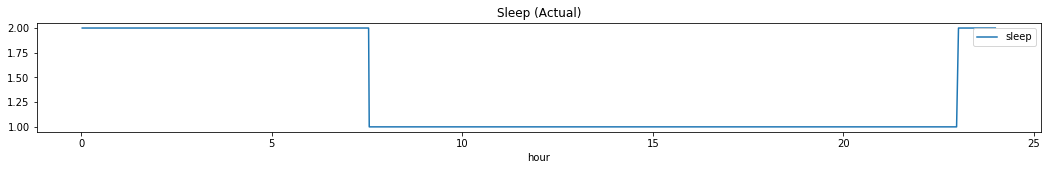

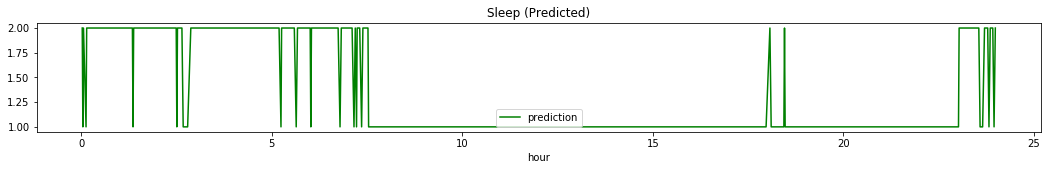

In [28]:
s4d6 = db.filter(db.arrays.IHI_PREDICTED_SLEEP, 'subject=4 and day=6').fetch(atts_only=True)
s4d6 = s4d6.sort_values(by='bin_millis')
s4d6['hour'] = s4d6['bin_millis'] / 3600000
plt.rcParams['figure.figsize'] = (18, 2)
s4d6[['hour','sleep']].plot(x='hour', title = "Sleep (Actual)")
s4d6[['hour','prediction']].plot(x='hour', color='green', title = "Sleep (Predicted)")
plt.show(block=True)

And we can look at every 1-minute bin we have predictions for and compare our predictions to ground truth:

In [29]:
result = db.grouped_aggregate(db.arrays.IHI_PREDICTED_SLEEP, "count(*)", "sleep, prediction").fetch(atts_only=True)
result

,sleep,prediction,count
0,1.0,1,78440.0
1,1.0,2,3828.0
2,2.0,2,36780.0
3,2.0,1,7523.0


The vast majority of our predictions are accurate but there's room to improve the model. Below is a visualization of the above table. We use randomized jitter to help visualize the relative number of points in each bin:

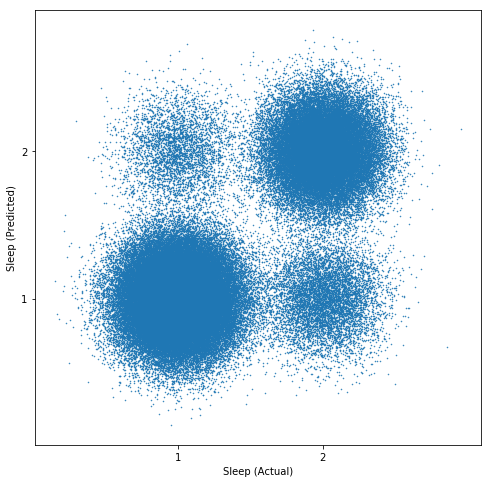

In [30]:
result = db.project(db.arrays.IHI_PREDICTED_SLEEP, "sleep, prediction")[:]
import matplotlib, numpy
def rand_jitter(arr):
     return arr + numpy.random.randn(len(arr)) * .2
plt.rcParams['figure.figsize'] = (8, 8)
matplotlib.pyplot.xticks([1,2])
matplotlib.pyplot.yticks([1,2])
matplotlib.pyplot.xlabel('Sleep (Actual)')
matplotlib.pyplot.ylabel('Sleep (Predicted)')
matplotlib.pyplot.plot(
     rand_jitter(result['sleep']), rand_jitter(result['prediction']), '.', ms=1)
plt.show()

## 3.5 What if?

What if we use a longer binning interval, say 10 minutes? What if we compute more features like accelerometer averages, min/max and median absolute deviation? What if we use a different model? Should we exclude certain subjects or certain days? 

The value add of SciDB for this kind of workflow is to allow fast re-calculations. Having all the code in the notebook with the parallel processing at our fingertips lets us iterate quickly and refine our approach in a reproducible fashion.